# Motivation
This notebook analyses the spreadsheet containing information on the reversals. This spreadsheet collects different features on the trades in an attempt of creating a binary classifier, this classifier will learn from the data collected and will predict the value of the `outcome` variable, which can be success of failre

# Data
The data has been collected in an spreadsheet containing trades both simulated and real. And the different trades have been classified into three types: continuation, counter and ranging. The independent variables gathered for each trade type are:
## Continuation trades
* id	id used in the screenshot folder to identify this record
* start	start of this trade
* timeframe	in the format 2D,D,H12,H8
* entry	price
* outcome	S=success;F=failure;B=breakeven
* ext_outcome. S=success;F=failure;B=breakeven
* RSI bounces. number of RSI bounces ocurring in the trend before entry
* No of candles. How many candles before occurred the bounce, from the entry of trade to the first bounce (without counting the entry candle)
* entry on RSI. Was the entry candle on RSI?
* length of trend. lenght of the preceding trend in number of candles. The valley before the continuation is not included in the count
* previous swings. Number of swings from the entry and counting the rebound before the entry (see screenshot below)
* space interswings. Comma separated numbers representing the number of candles between swings from the most recent to the oldest
* length in pips. From the beginning of the trade to the entry price in number of pips
strong trend	TRUE of the preceding trend was strong
* trend angle. Measured with Oanda after hitting the auto scale button+lock scalde button and the end of the trend line is the IC+1 when it touches the entry price
* bounce length. Length in number of candles for each of the bounces (in the order from the most recent to the oldest)
* bounce pips. Length from the horizontal line defined by IC until the highest point of the bounce (considering wicks also)
* inn_bounce. Number of candles of the inner bounce (see screenshots below)
indecission	Number of candles the price stays in S/R, without considering the bounce and only considering the candles pre/post bounce
* retraced.	Only relevant for outcome=F, how many pips from the S/L the trade reversed?. If n.a., then it means that the trade did not reversed last time that the price was below/above this level assuming that a possible counter could happen

## Dependencies

In [1275]:
import pandas as pd
import numpy as np
import pdb
import re
import seaborn as sns
from pandas.plotting import scatter_matrix
from sklearn.metrics import confusion_matrix,precision_score
from sklearn.model_selection import train_test_split

%matplotlib inline

# Continuation trades

First, let's create a function to read-in a .csv file containing the data andstore it in a dataframe:

In [1276]:
def read_tradedata(tradefile,sep,na_values):
    '''
    Parameters
    ----------
    tradefile : str, required
                Path to file containing the trade data
    sep : str, optionsl
          Field separator used in the file. i.e. ',' (comma separated values), '\t' (tab-separated values)
    na_values : list, optional
                Additional list of strings to recognize as NA/NaN. i.e. ['n.a.']
    
    Returns
    -------
    A Pandas dataframe
    '''
    DF=pd.read_csv(tradefile,sep=sep,na_values=na_values)
    
    return DF

contDF=read_tradedata('/Users/ernesto/Downloads/Screenshot analysis - continuations.csv',sep=",",na_values=["n.a.","n.a"])

contDF.shape

(151, 23)

And some information about contDF:

In [1277]:
contDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151 entries, 0 to 150
Data columns (total 23 columns):
id                         151 non-null object
start                      151 non-null object
timeframe                  151 non-null object
entry                      151 non-null float64
outcome                    151 non-null object
ext_outcome                151 non-null object
Candle +1 against trade    151 non-null bool
RSI bounces                151 non-null int64
No of candles              120 non-null float64
bounce length              120 non-null object
bounce (pips)              151 non-null int64
inn_bounce                 151 non-null int64
indecission                151 non-null int64
entry on RSI               151 non-null bool
length of trend            151 non-null int64
previous swings            151 non-null int64
space interswings          151 non-null object
length in pips             151 non-null int64
strong trend               151 non-null bool
trend angle  

* Conversion to right types<br>
Let's convert now the `start` and `last time` variables to DateTime

In [1278]:
contDF['start']= pd.to_datetime(contDF['start'])
contDF['last time']= pd.to_datetime(contDF['last time'])

## Cleaning the n.a. values
The following predictors have n.a. values and the strategy I will follow will depend on each case:

* No of candles (will replace the n.a. by 0)

In [1279]:
contDF["No of candles"].fillna(0, inplace=True)

* Bounce length (will replace the n.a. by 0)

In [1280]:
contDF["bounce length"].fillna(0, inplace=True)

## Transforming

In [1281]:
transl_dict={ 
        'S':1,
        'F':0, 
        True:1, 
        False:0
    }
def digit_binary(x,transl_dict,name):
    '''
    This function will replace the values in categorical
    binary variables by 1 and 0
    
    Parameters
    ----------
    transl_dict: dict
                 Keys will be the old categorical names and Values
                 will be 1 and 0. For example:
                 transl_dict={ 
                            'S':1,
                            'F':0, 
                            True:1, 
                            False:0
                            }
    name: str
          Name of the column to modify
        
    Returns
    -------
    The new label for the categorical variable
    '''
    
    return transl_dict[x[name]]

contDF['ext_outcome']=contDF.apply(digit_binary,axis=1,transl_dict=transl_dict, name='ext_outcome')
contDF['Candle +1 against trade']=contDF.apply(digit_binary,axis=1,transl_dict=transl_dict, name='Candle +1 against trade')
contDF['entry on RSI']=contDF.apply(digit_binary,axis=1,transl_dict=transl_dict, name='entry on RSI')
contDF['strong trend']=contDF.apply(digit_binary,axis=1,transl_dict=transl_dict, name='strong trend')

## Creation of new variables
In this section I create new variables derived from the initial set of features. 
The first one is a variable named 'length in pips (norm)':

In [1282]:
times_dict={ '2D': 48, 'D' :24, 'H12' : 12, 'H10': 10, 'H8':8}

def norm_lengths(x, times_dict):
    '''
    Function to normalize the length in pips by number of candles and timeframe
    
    Parameters
    ----------
    x = Dataframe row
    times_dict = dict
        
    Returns
    -------
    A float with normalized length (pips)
    '''
    hours=times_dict[x['timeframe']]
    candle_length=x['length of trend']
    length_pips=x['length in pips']
    norm_length=length_pips/(candle_length*hours)
    
    return norm_length

contDF['length in pips (norm)']=contDF.apply(norm_lengths,axis=1,times_dict=times_dict)

* bounce (ratio)
This derived variable is created after dividing the 2 variables `inn_bounce` and `indecission`

In [1283]:
def divide_bounce(x):
    '''
    This function will calculate the following division: inn_bounce/indecission
    
    Parameters
    ----------
    x = Dataframe row
        
    Returns
    -------
    A float that is the result of the division
    '''

    res=x['inn_bounce']/x['indecission']
    
    return res

contDF['bounce (ratio)']=contDF.apply(divide_bounce,axis=1)

## Initial exploration of the data

First things first, let's examine if we have a significant number of records per category of the dependent variable (outcome in this case), since it is really very important to have enough records to establish solid conclusions

In [1284]:
outcome_ix=5 # 4=outcome and 5= ext_outcome
outcome_lab="ext_outcome"
contDF.iloc[:,outcome_ix].value_counts()

1    105
0     46
Name: ext_outcome, dtype: int64

For now I am not going to consider the trades having an outcome of 'B'. So, let's remove them from the dataframe:

In [1285]:
contDF=contDF[contDF.outcome != 'B']

### Candle +1 against trade
This variable is True when the IC+1 is against the trade. I will here analyze the influence of this variable on the outcome

Let's create a contigency table analysing the relationship between these 2 variables:

In [1286]:
div_class=pd.crosstab(contDF.iloc[:,outcome_ix], contDF['Candle +1 against trade'],margins=True)
print(div_class)

Candle +1 against trade    0   1  All
ext_outcome                          
0                         27  19   46
1                         81  24  105
All                      108  43  151


It's is easier to visualize the relationship if we calculate the percentages:

In [1287]:
propCp1=(div_class/div_class.loc["All"])*100
print(propCp1)

Candle +1 against trade      0           1         All
ext_outcome                                           
0                         25.0   44.186047   30.463576
1                         75.0   55.813953   69.536424
All                      100.0  100.000000  100.000000


* Conclusion <br>
Within the trades with IC+1 against the trade there are {{'%.1f' % propCp1.iloc[0, 1]}}% of failures and {{'%.1f' % propCp1.iloc[1, 1]}}% of successes<br>
Within the trades with IC+1 in favour of the trade there are {{'%.1f' % propCp1.iloc[0, 0]}}% of failures and {{'%.1f' % propCp1.iloc[1, 0]}}% of successes

###  RSI bounces
Let's examine if there is a correlation between the number of bounces and the outcome of the trade

As an initial exploration I will create a boxplot displaying the data

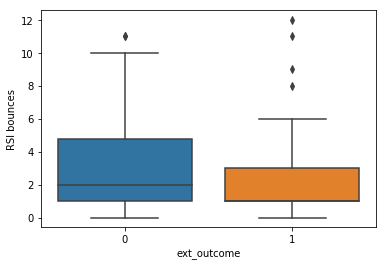

In [1288]:
ax = sns.boxplot(x=outcome_lab, y="RSI bounces", data=contDF)

* Mean for each category

In [1289]:
contDF.groupby(outcome_lab).agg({'RSI bounces': 'mean'})

,RSI bounces
ext_outcome,
0,3.195652
1,2.095238


* Median for each category

In [1290]:
medianBounce=contDF.groupby(outcome_lab).agg({'RSI bounces': 'median'})
print(medianBounce)

             RSI bounces
ext_outcome             
0                      2
1                      1


* Conclusion <br>
The median number of bounces for successful trades is {{'%.0f' % medianBounce.iloc[1,0]}}<br>
The median number of bounces for failed trades is {{'%.0f' % medianBounce.iloc[0,0]}}<br>

* Distribution of the number of bounces<br>
For this particular task I will create a count plot in order to plot the RSI bounces for both the successful and the failed trades

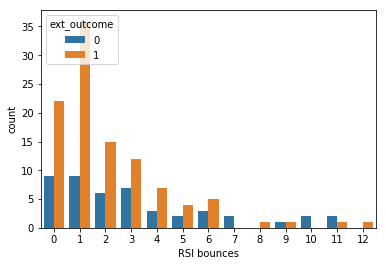

In [1291]:
ax = sns.countplot(x="RSI bounces",hue=outcome_lab, data=contDF)

Now, let's calculate the normalized number of bounces, as the 2 categories of the outcome variables are imbalanced

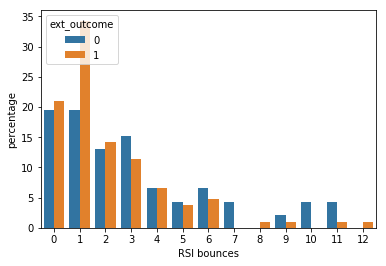

In [1292]:
contDF_counts = (contDF.groupby([outcome_lab])['RSI bounces']
                  .value_counts(normalize=True)
                  .rename('percentage')
                  .mul(100)
                  .reset_index()
                  .sort_values('RSI bounces'))

p = sns.barplot(x="RSI bounces", y="percentage", hue=outcome_lab, data=contDF_counts)

* Conclusion<br>
The ideal situation for having a S trade is to have either 1 or 2 bounces

### retraced
This integer variable represents the number of pips from the S/L from where the failing trade retraced and hitted the target. Let's start analyzing the number of trades that retraced:

In [1293]:
len(contDF[contDF.retraced.notnull()])

50

Now, let's examine the distribution of the data:

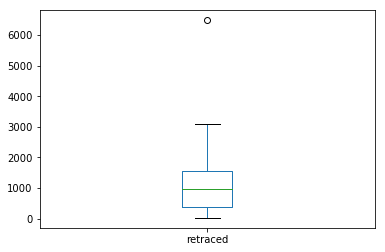

In [1294]:
ret=contDF[contDF.retraced.notnull()].retraced.astype(int)
ret.plot(kind="box")

In [1295]:
print(ret.describe())

count      50.000000
mean     1104.920000
std      1089.880987
min        20.000000
25%       372.500000
50%       974.000000
75%      1557.750000
max      6483.000000
Name: retraced, dtype: float64


### No of candles
This variable represents the number of candles since the beginning of the trade until the first RSI bounce. I am going compare the distribution of this variable depending on the `outcome` variable.<br>

As an initial exploration I will create a boxplot displaying the data:

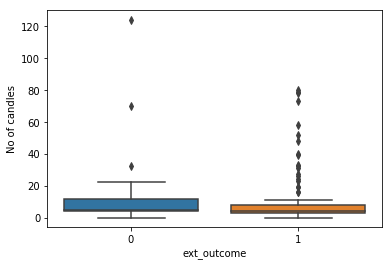

In [1296]:
ax = sns.boxplot(x=outcome_lab, y="No of candles", data=contDF)

* Mean for each category

In [1297]:
contDF.groupby(outcome_lab).agg({'No of candles': 'mean'})

,No of candles
ext_outcome,
0,10.804348
1,10.771429


* Median for each category

In [1298]:
contDF.groupby(outcome_lab).agg({'No of candles': 'median'})

,No of candles
ext_outcome,
0,5.0
1,4.0


Let's analyze the distribution with a histogram

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1209c4588>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x11f240978>], dtype=object)

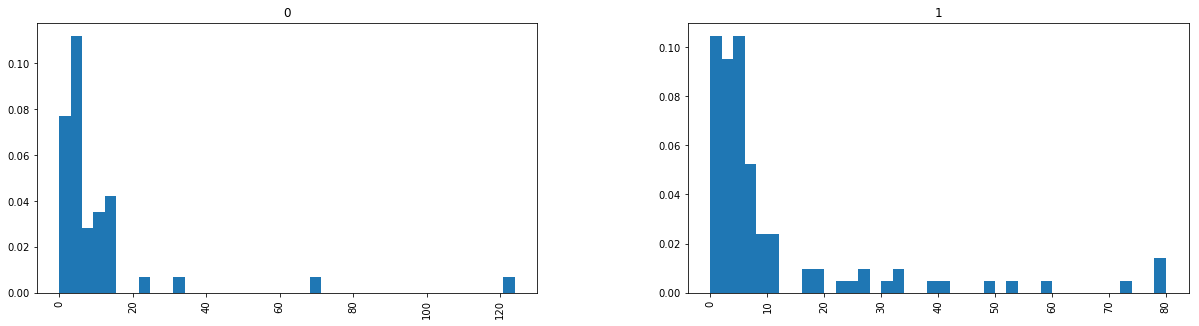

In [1299]:
contDF['No of candles'].hist(by=contDF[outcome_lab],figsize=(20,5),bins=40,normed=True)

### entry on RSI
This boolean variable will be True if the entry of the trade is in oversold/overbought RSI
Firs, let's see the counts for each category of the variable

In [1300]:
contDF['entry on RSI'].value_counts()

0    119
1     32
Name: entry on RSI, dtype: int64

Let's compare the proportions for this variable between the 2 categories of the `outcome` variable

In [1301]:
div_class=pd.crosstab(contDF.iloc[:,outcome_ix], contDF['entry on RSI'],margins=True)
print(div_class)

entry on RSI    0   1  All
ext_outcome               
0              37   9   46
1              82  23  105
All           119  32  151


It's is easier to visualize the relationship if we calculate the percentages:

In [1302]:
prop=(div_class/div_class.loc["All"])*100
print(prop)

entry on RSI           0        1         All
ext_outcome                                  
0              31.092437   28.125   30.463576
1              68.907563   71.875   69.536424
All           100.000000  100.000  100.000000


* Conclusion <br>
Within the trades having entry on RSI there are {{'%.1f' % prop.iloc[0, 1]}}% of failures and {{'%.1f' % prop.iloc[1, 1]}}% of successes<br>
Within the trades not having an entry on RSI there are {{'%.1f' % prop.iloc[0, 0]}}% of failures and {{'%.1f' % prop.iloc[1, 0]}}% of successes

### length of trend
This quantitative discrete variable measures the length of the trade measured in term of the number of candles. Let's start comparing the distribution of this variable for the different categories of the `outcome` variable

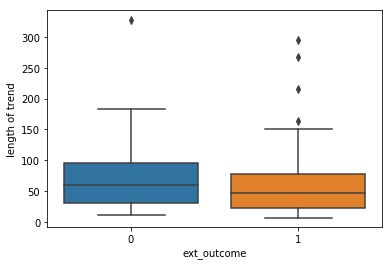

In [1303]:
ax = sns.boxplot(x=outcome_lab, y="length of trend", data=contDF)

<class 'matplotlib.axes._subplots.AxesSubplot'>


(0, 150)

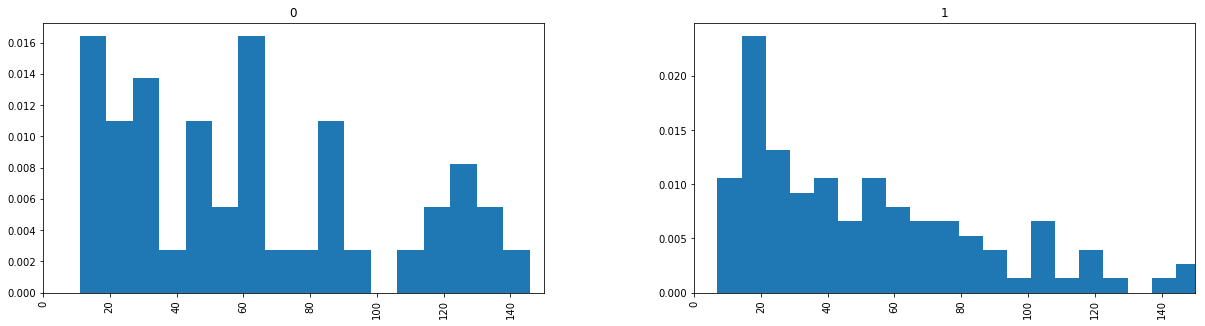

In [1304]:
axList=contDF['length of trend'].hist(by=contDF[outcome_lab],figsize=(20,5),bins=40,normed=True)
print(type(axList[0]))
axList[0].set_xlim((0,150))
axList[1].set_xlim((0,150))

* Mean for each category

In [1305]:
contDF.groupby(outcome_lab).agg({'length of trend': 'mean'})

,length of trend
ext_outcome,
0,70.847826
1,58.590476


* Median for each category

In [1306]:
contDF.groupby(outcome_lab).agg({'length of trend': 'median'})

,length of trend
ext_outcome,
0,59.5
1,47.0


###  trend angle
This quantitative discrete variable measures the angle of a particular trend. Let's start comparing the distribution of this variable for the different categories of the `outcome` variable

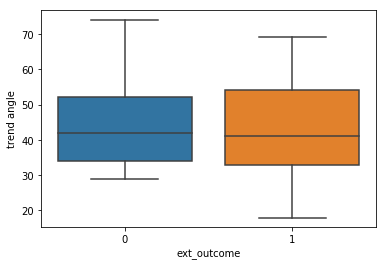

In [1307]:
ax = sns.boxplot(x=outcome_lab, y="trend angle", data=contDF)

* Mean for each category

In [1308]:
contDF.groupby(outcome_lab).agg({'trend angle': 'mean'})

,trend angle
ext_outcome,
0,44.260870
1,43.180952


* Median for each category

In [1309]:
contDF.groupby(outcome_lab).agg({'trend angle': 'median'})

,trend angle
ext_outcome,
0,42
1,41


* Histogram

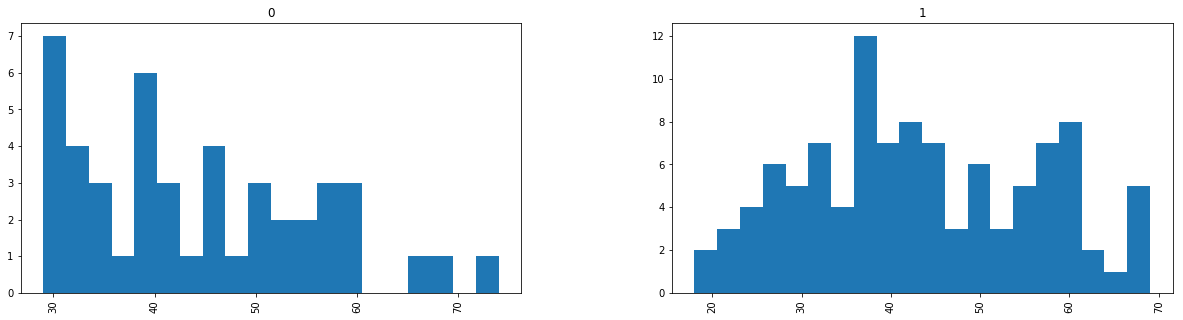

In [1310]:
axList=contDF['trend angle'].hist(by=contDF[outcome_lab],figsize=(20,5),bins=20)

### inn_bounce
Integer variable representing the number of candles of the inner bounce. Let's start comparing the distribution of this variable for the different categories of the `outcome` variable

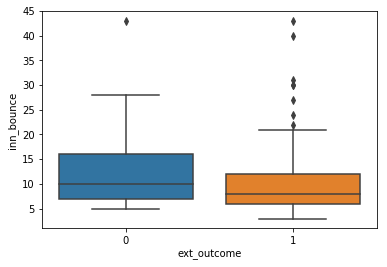

In [1311]:
ax = sns.boxplot(x=outcome_lab, y="inn_bounce", data=contDF)

* Mean for each category

In [1312]:
contDF.groupby(outcome_lab).agg({'inn_bounce': 'mean'})

,inn_bounce
ext_outcome,
0,13.195652
1,10.276190


* Median for each category

In [1313]:
contDF.groupby(outcome_lab).agg({'inn_bounce': 'median'})

,inn_bounce
ext_outcome,
0,10
1,8


* Histogram

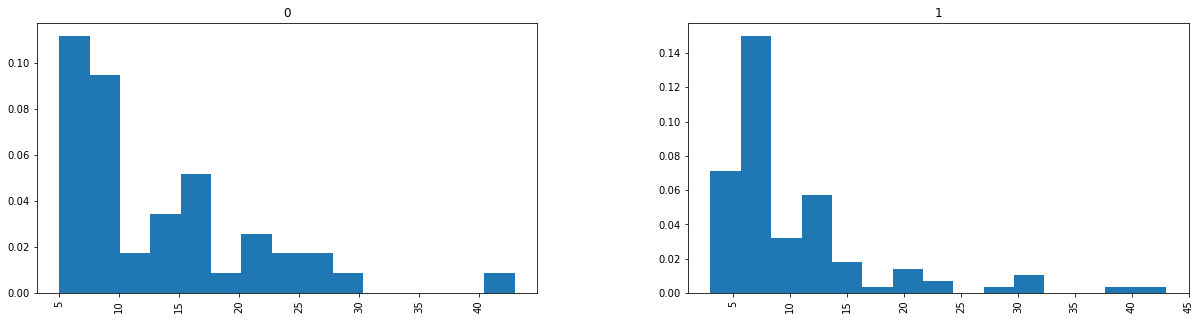

In [1314]:
axList=contDF['inn_bounce'].hist(by=contDF[outcome_lab],figsize=(20,5),bins=15,normed=True)

### indecission
Integer variable representing the number of candles the price stays in S/R, without considering the bounce and only considering the candles pre/post bounce. Let's start comparing the distribution of this variable for the different categories of the `outcome` variable

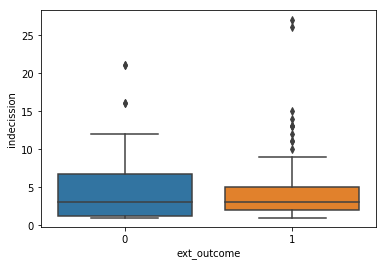

In [1315]:
ax = sns.boxplot(x=outcome_lab, y="indecission", data=contDF)

* Mean for each category

In [1316]:
contDF.groupby(outcome_lab).agg({'indecission': 'mean'})

,indecission
ext_outcome,
0,5.130435
1,4.409524


* Median for each category

In [1317]:
contDF.groupby(outcome_lab).agg({'indecission': 'median'})

,indecission
ext_outcome,
0,3
1,3


* Histogram

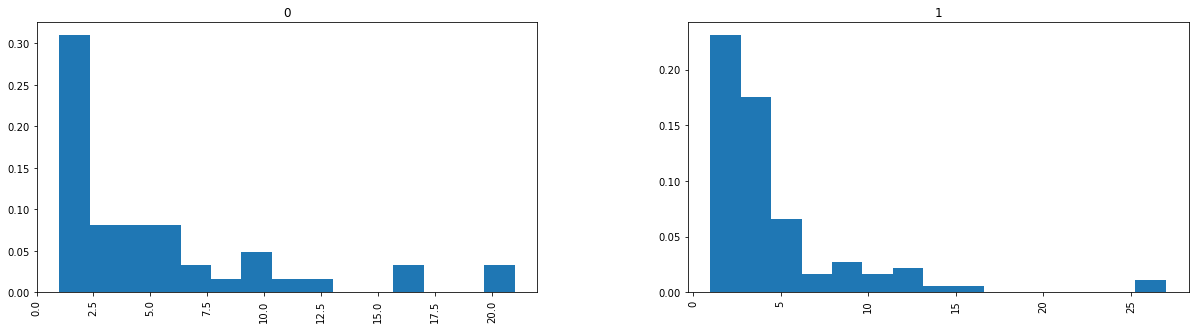

In [1318]:
axList=contDF['indecission'].hist(by=contDF[outcome_lab],figsize=(20,5),bins=15,normed=True)

### bounce (ratio)
This quantitative variable is the result of dividing the `inn_bounce` and `indecission` for a particular trade.
Let's compare the proportions for this variable between the 2 categories of the `outcome` variable

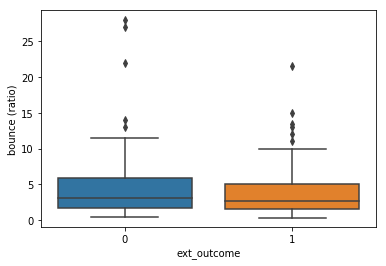

In [1319]:
ax = sns.boxplot(x=outcome_lab, y="bounce (ratio)", data=contDF)

* Mean for each category

In [1320]:
contDF.groupby(outcome_lab).agg({'bounce (ratio)': 'mean'})

,bounce (ratio)
ext_outcome,
0,5.460448
1,3.910357


* Median for each category

In [1321]:
contDF.groupby(outcome_lab).agg({'bounce (ratio)': 'median'})

,bounce (ratio)
ext_outcome,
0,3.125000
1,2.666667


* Histogram

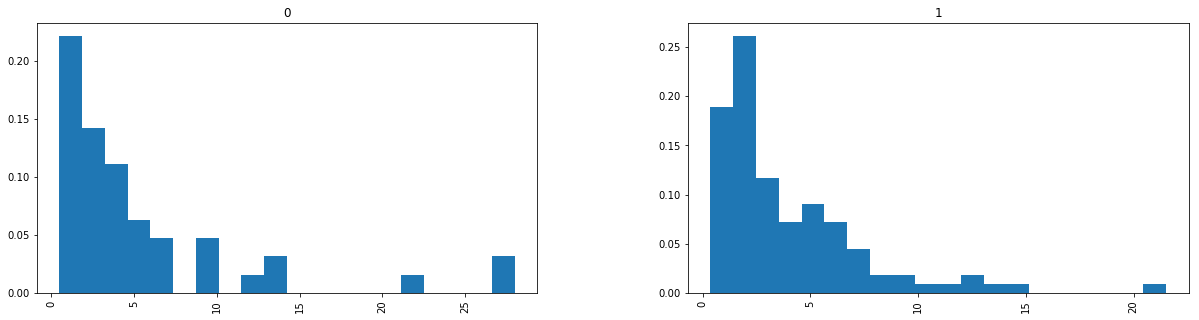

In [1322]:
axList=contDF['bounce (ratio)'].hist(by=contDF[outcome_lab],figsize=(20,5),bins=20,normed=True)

### Strong trend
Boolean that is TRUE when trend is strong, FALSE otherwise.

Let's compare the proportions for this variable between the 2 categories of the `outcome` variable

In [1323]:
div_class=pd.crosstab(contDF.iloc[:,outcome_ix], contDF['strong trend'],margins=True)
print(div_class)

strong trend   0   1  All
ext_outcome              
0             25  21   46
1             49  56  105
All           74  77  151


It's is easier to visualize the relationship if we calculate the percentages:

In [1324]:
propStrength=(div_class/div_class.loc["All"])*100
print(propStrength)

strong trend           0           1         All
ext_outcome                                     
0              33.783784   27.272727   30.463576
1              66.216216   72.727273   69.536424
All           100.000000  100.000000  100.000000


* Conclusion <br>
Within the trades trending strongly there are {{'%.1f' % propStrength.iloc[0, 1]}}% of failures and {{'%.1f' % propStrength.iloc[1, 1]}}% of successes<br>
Within the trades not trending strongly there are {{'%.1f' % propStrength.iloc[0, 0]}}% of failures and {{'%.1f' % propStrength.iloc[1, 0]}}% of successes

### length in pips (norm)

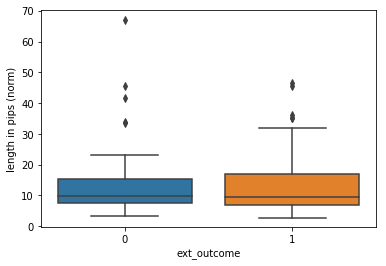

In [1325]:
ax = sns.boxplot(x=outcome_lab, y="length in pips (norm)", data=contDF)

* Mean for each category

In [1326]:
contDF.groupby(outcome_lab).agg({'length in pips (norm)': 'mean'})

,length in pips (norm)
ext_outcome,
0,14.150950
1,12.819903


* Median for each category

In [1327]:
contDF.groupby(outcome_lab).agg({'length in pips (norm)': 'median'})

,length in pips (norm)
ext_outcome,
0,9.674563
1,9.595679


### bounce length
This variable is a comma separated list of integers representing how wide (in number of candles) each of the RSI bounces is. This variable requires a little bit of preprocessing, and I will write a function that calculates the total length (in number of candles) by adding the length of each of the bounces

In [1328]:
def sum_lengths(x):
    '''
    Function to calculate the sum (in number of candles)
    of all the RSI bounces
    
    Parameters
    ----------
    x = string with a comma separated list of numbers
        i.e. 1,4,2,3
        
    Returns
    -------
    An integer representing the total bounce length
    '''
    
    return sum([int(i) for i in x.split(",")])
    

And I will apply the `sum_lengths` function and put the results in a new column named `sum_bounces`

In [1329]:
contDF['sum_bounces']=contDF['bounce length'].astype(str).apply(sum_lengths)

Now, I will plot the distribution of this new variable on each `outcome`category:

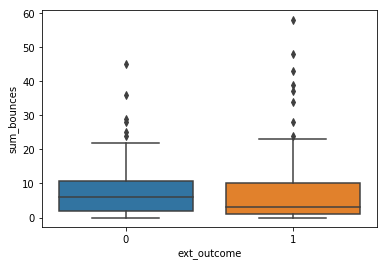

In [1330]:
ax = sns.boxplot(x=outcome_lab, y="sum_bounces", data=contDF)

* Mean for each category

In [1331]:
contDF.groupby(outcome_lab).agg({'sum_bounces': 'mean'})

,sum_bounces
ext_outcome,
0,9.456522
1,7.676190


* Median for each category

In [1332]:
contDF.groupby(outcome_lab).agg({'sum_bounces': 'median'})

,sum_bounces
ext_outcome,
0,6
1,3


In [1333]:
* Histogram

SyntaxError: can't use starred expression here (<ipython-input-1333-48fdfaf4761b>, line 1)

In [ ]:
axList=contDF['sum_bounces'].hist(by=contDF[outcome_lab],figsize=(20,5),bins=20,normed=True)

### bounce (pips)
This quantitative variable represents the length from the horizontal line defined by IC until the highest point of the bounce (considering wicks also).  Let's start comparing the distribution of this variable for the different categories of the `outcome` variable

In [ ]:
ax = sns.boxplot(x=outcome_lab, y="bounce (pips)", data=contDF)

* Mean for each category

In [ ]:
contDF.groupby(outcome_lab).agg({'bounce (pips)': 'mean'})

* Median for each category

In [ ]:
contDF.groupby(outcome_lab).agg({'bounce (pips)': 'median'})

In [ ]:
axList=contDF['bounce (pips)'].hist(by=contDF[outcome_lab],figsize=(20,5),bins=20,normed=True)

### previous swings
This quantitative discrete variable is used to represent the number of swings from the entry. Let's start comparing the distribution of this variable for the different categories of the `outcome` variable

In [ ]:
ax = sns.boxplot(x=outcome_lab, y="previous swings", data=contDF)

* Mean for each category

In [ ]:
contDF.groupby(outcome_lab).agg({'previous swings': 'mean'})

* Median for each category

In [ ]:
contDF.groupby(outcome_lab).agg({'previous swings': 'median'})

### last time
This datetime variable represents the last time the price was over/below the entry price level. The first to do is to create a new datetime variable representing the difference (in days) between the entry datetime (start column) and the last time datetime.

In [ ]:
contDF['diff']=(contDF['start']-contDF['last time'])

In [ ]:
contDF['diff']=contDF['diff'].apply(lambda x: x.days)

Now, let's examine the distribution of this newly created `diff` variable in the 2 `outcome` categories

In [ ]:
ax = sns.boxplot(x="outcome", y="diff", data=contDF)

* Mean for each category

In [ ]:
contDF.groupby(outcome_lab).agg({'diff': 'mean'})

* Median for each category

In [ ]:
contDF.groupby(outcome_lab).agg({'diff': 'median'})

* Histogram

In [ ]:
axList=contDF['diff'].hist(by=contDF[outcome_lab],figsize=(20,5),bins=10,normed=True)

### Correlations
In this section, I will analyze the correlation of each of the numerical variables in the dataframe

In [ ]:
attributes = ["inn_bounce", "indecission", "trend angle","length of trend","RSI bounces","sum_bounces"]
scatter_matrix(contDF[attributes], figsize=(12, 8))

* Conclusion<br>
After inspecting the plots we see that there are the following correlations:<br>
-negative correlation between trend angle and length of trend<br>
-positive correlation between sum_bounces and RSI bounces

Let's calculate now the multicollinearity for our predictors by calculating the eigen values and vectors:
First, let's convert the numerical attributes to a numpy array:

In [ ]:
attrb_arrays=contDF[attributes].values

Let's calculate the correlation matrix:

In [ ]:
corr = np.corrcoef(attrb_arrays, rowvar=0)

And we calculate the Eigen values and vectors:

In [ ]:
 w, v = np.linalg.eig(corr)

In [ ]:
print(w)

There are not values close to 0, so there is not multicollinearity

## Conclusions

This section collects all the conclusions derived from the first exploration of the data. It shows the variable that are relevant and irrelevant for the fate of the continuation trades.<br>
* Relevant:<br>
1) Candle +1 against trade <br>
Within the trades with IC+1 against the trade there are {{'%.1f' % propCp1.iloc[0, 1]}}% of failures and {{'%.1f' % propCp1.iloc[1, 1]}}% of successes<br>
Within the trades with IC+1 in favour of the trade there are {{'%.1f' % propCp1.iloc[0, 0]}}% of failures and {{'%.1f' % propCp1.iloc[1, 0]}}% of successes<br>
2) RSI bounces <br>
The median number of bounces for successful trades is {{'%.0f' % medianBounce.iloc[1,0]}}<br>
The median number of bounces for failed trades is {{'%.0f' % medianBounce.iloc[0,0]}}<br>
The ideal situation for having a S trade is to have either 1 or 2 bounces<br>
3) No of candles <br>
The median number of candles for S is 4 and for F is 5<br>
5) Length of the trend <br>
The median length of the trade for S trades (50) is lower than for F trades (66). Also, after inspecting the distribution, we see that the majority of S trades have a length ranging from [15-60]<br>
6) inn_bounce <br>
The signal is strong. The bounces are smaller for S trades.
cutoff-> trades having >12<br>
7) indecission <br>
Signal is weak. The number of candles in indecission is smaller in S trades
cutoff-> trades having >6<br>
8) bounce (ratio) <br>
Signal is weak. The ratio inn_bounce/indecission is slightly higher for `S` trades<br>
8) Strong trend<br>
Signal is strong. The trend is stronger in S trades<br>
9) bounce length<br>
Signal is strong. The median bounce length is smaller in S trades
cutoff--> trades having a length > 12<br>
10) bounce (pips)<br>
Signal is strong. The median length in pips for the bounce is smaller in S trades
* Irrelevant:<br>

1) trend angle<br>
No significative differences between S and F trades<br>
2) last time <br>
No significative differences between S and F trades<br>
3) length in pips (norm) <br>
No significative differences between S and F trades<br>
4) previous swings <br>
No significative difference between S and F trades in terms of the number of previous swings from the entry
5) entry on RSI <br>
No significative differences between S and F trades<br>

## Calculating points
This section will calculate a total score for each trade that will be used to predict the outcome.<br>

### Splitting the data into training and test sets
Let's split the data into training and test sets. We are going to use a test set size of 0.33

In [1334]:
train, test = train_test_split(contDF,
                               test_size=0.33
                              )

First, let's create a function to calculate the points

In [1335]:
def calculate_points(row,attribs):
    '''
    Function to calculate the points for a particular trade
    
    Parameters
    ----------
    row : dataframe row
    attribs : list of dicts
              The dict has the following format:
              {'attr' : 'RSI bounces',
               'cutoff' : 3,
               'points' : 2}
               
    Returns
    -------
    Returns a score for this trade
    
    '''
    score=0
    for a in attribs:
        value=row[a['attr']]
        cutoff=a['cutoff']
        points=a['points']
        if cutoff =='bool':
            if a['rel'] == 'is_true':
                if value == True or value == 1:
                    score+=points
                if value == False  or value == 0:
                    score+=-1*points
        else:
            if a['rel'] == 'less':
                if value < cutoff: 
                    score+=points
                if value >= cutoff: 
                    score+=-1*points
            elif a['rel'] == 'range':
                p=re.compile("(\d+)-(\d+)")
                m=p.match(cutoff)
                upp=int(m.group(2))
                low=int(m.group(1))
                if value >=low and value <=upp:
                    score+=points
                else:
                    score+=-1*points
                
    return score

In [1336]:
attbs=[]

attbs.append({
        'attr' : 'RSI bounces',
        'cutoff' : 5,
        'rel' : 'less',
        'points' : 2
        })
attbs.append( {
        'attr' : 'length of trend',
        'cutoff' : '15-70',
        'rel' : 'range',
        'points' : 1
        })
attbs.append( {
        'attr' : 'inn_bounce',
        'cutoff' : 11,
        'rel' : 'less',
        'points' : 1
        })
attbs.append( {
        'attr' : 'strong trend',
        'cutoff' : 'bool',
        'rel' : 'is_true',
        'points' : 2
        })
attbs.append( {
        'attr' : 'sum_bounces',
        'cutoff' : 10,
        'rel' : 'less',
        'points' : 2
        })
attbs.append( {
        'attr' : 'bounce (pips)',
        'cutoff' : 3000,
        'rel' : 'less',
        'points' : 2
        })

Now, let's apply the calculate_points on each row for the training and the test set

In [1337]:
train['score']=train.apply(calculate_points, axis=1, attribs=attbs)
test['score']=test.apply(calculate_points, axis=1, attribs=attbs)

/Users/ernesto/bin/anaconda/envs/python3/lib/python3.5/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/ernesto/bin/anaconda/envs/python3/lib/python3.5/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


### Calculating cutoff score
* Mean

In [1338]:
train.groupby(outcome_lab).agg({'score': 'mean'})

,score
ext_outcome,
0,2.800000
1,4.422535


* Median

In [1339]:
train.groupby(outcome_lab).agg({'score': 'median'})

,score
ext_outcome,
0,4
1,6


* Histogram

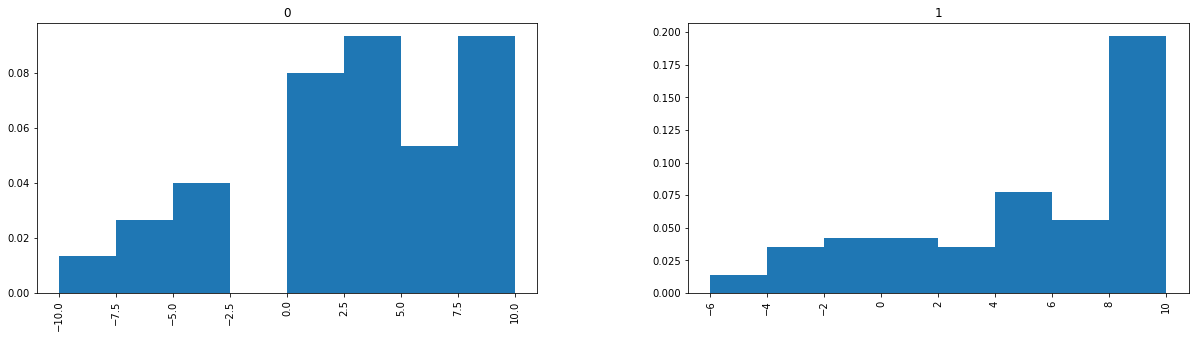

In [1340]:
axList=train['score'].hist(by=train[outcome_lab],figsize=(20,5),bins=8,normed=True)

### Making predictions and performance evaluation
We will use different cutoffs and make predictions using these using the test set

Let's create a new dataframe only with the columns we are interested in:

In [1341]:
scoreDF=test.iloc[:,[outcome_ix,26]]

In [1342]:
def predictOutcome(row, cutoff):
    pred=None
    if row['score'] >cutoff:
        pred=1
    else:
        pred=0
    return pred

In [1343]:
scoreDF['predict']=scoreDF.apply(predictOutcome,axis=1,cutoff=6)

/Users/ernesto/bin/anaconda/envs/python3/lib/python3.5/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


* Performance evaluation

In [1344]:
(tn, fp, fn, tp)=confusion_matrix(scoreDF['ext_outcome'], scoreDF['predict']).ravel()
print("TP:"+str(tp))
print("TN:"+str(tn))
print("FN:"+str(fn))
print("FP:"+str(fp))

TP:15
TN:14
FN:19
FP:2


    * Precision

In [1345]:
print(tp/(tp+fp))

0.882352941176


* Recall

In [1346]:
print(tp/(tp+fn))

0.441176470588


### Using a Binary classifier
First, let's prepare the data by separating the data into labels (dependent variable, which is the variable we try to predict) and features (the independent variables that are going to be used for the model)

In [1347]:
labels=contDF['ext_outcome']
features=contDF.drop(["ext_outcome","outcome"],axis=1)

We need also to remove some features that will be not accepted by the classifier or are not useful

In [1348]:
features=features.drop(["id","start","timeframe","entry","retraced","last time","target","bounce length","space interswings"],axis=1)

Now, let's split our data into training and test sets. In this case, the test_size=0.33

In [1349]:
train, test, train_labels, test_labels = train_test_split(features,
                                                          labels,
                                                          test_size=0.33,
                                                          random_state=42)

As the counts for each outcome category are unbalanced, I will oversample using SMOTE:

In [1350]:
from imblearn.over_sampling import SMOTE

train_resampled, trainlabels_resampled = SMOTE().fit_sample(train,train_labels)

Let's check the balanced counts:

In [1351]:
from collections import Counter

print(sorted(Counter(trainlabels_resampled).items()))

[(0, 73), (1, 73)]


#### naive_bayes

Building and Evaluating the Model for the non oversampled train dataset

In [1352]:
from sklearn.naive_bayes import GaussianNB

# Initialize our classifier
gnb = GaussianNB()

# Train our classifier
model = gnb.fit(train, train_labels)

In [1353]:
# Make predictions
preds = gnb.predict(test)

In [1354]:
from sklearn.metrics import accuracy_score

# Evaluate accuracy
print(accuracy_score(test_labels, preds))

0.62


Now, with the oversampled train dataset

In [1355]:
# Train our classifier
model = gnb.fit(train_resampled,  trainlabels_resampled)

# Make predictions
preds = gnb.predict(test)

# Evaluate accuracy
print(accuracy_score(test_labels, preds))

0.64


**Conclusion** It is slightly better using oversampling

#### Using SGDClassifier
First, let's use the non oversampled train dataset

In [1356]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier()
sgd=sgd_clf.fit(train,train_labels)

/Users/ernesto/bin/anaconda/envs/python3/lib/python3.5/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


In [1357]:
preds=sgd_clf.predict(test)

In [1358]:
print(accuracy_score(test_labels, preds))

0.38


Now, with the oversampled train dataset

In [1359]:
sgd_clf = SGDClassifier()
sgd=sgd_clf.fit(train_resampled,trainlabels_resampled)
preds=sgd_clf.predict(test)
print(accuracy_score(test_labels, preds))

0.7


/Users/ernesto/bin/anaconda/envs/python3/lib/python3.5/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


#### Using Logistic Regression  
First, let's use the non oversampled train dataset

In [1360]:
from sklearn.linear_model import LogisticRegression
logisticRegr = LogisticRegression(verbose=1)

Now, we train the model with the training set:

In [1361]:
m=logisticRegr.fit(train, train_labels)

[LibLinear]

Now, let's measue model performance
First, we are going to make predictions using our new model and the test data

In [1362]:
predictions = logisticRegr.predict(test)

We can use the score function in order to calculate the mean accuracy on the test data and labels

In [1363]:
score = logisticRegr.score(test, test_labels)
print(score)

0.66


In order to visualize the correctness of our predictions, we can also create a confusion matrix:

In [1364]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

cm = metrics.confusion_matrix(test_labels, predictions)
print(cm)

[[ 4 14]
 [ 3 29]]


The matrix above can be embellished by using seaborn:

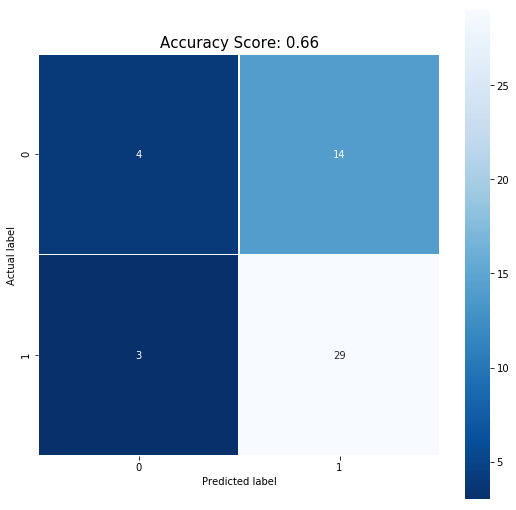

In [1365]:
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);

Now, let's try with the oversampled train dataset

In [1366]:
from sklearn.linear_model import LogisticRegression
logisticRegr = LogisticRegression(verbose=1)

Now, we train the model with the training set:

In [1367]:
m=logisticRegr.fit(train_resampled,trainlabels_resampled)

[LibLinear]

Now, let's measue model performance
First, we are going to make predictions using our new model and the test data

In [1368]:
predictions = logisticRegr.predict(test)

We can use the score function in order to calculate the mean accuracy on the test data and labels

In [1369]:
score = logisticRegr.score(test, test_labels)
print(score)

0.5


**Conclusion:** It is worst to oversample in terms of score

* Examining the influence of each predictor on the outcome

In [1370]:
stds=np.std(train, 0)

print(stds.values*m.coef_)

[[-0.44912792 -1.08949314 -0.0983037  -0.19124925 -0.30224798  0.42703125
  -0.21518266  0.22209904 -0.31361307 -0.09201393 -0.09627279 -0.10426247
   0.48757632 -0.10753869  0.63642585]]


In [1371]:
keys=list(train.columns)
values_10=list(stds.values*m.coef_)[0]*10

coefficients=dict(zip(keys,values_10))
print(coefficients)

{'length of trend': 2.2209903608565011, 'inn_bounce': -3.0224797864689079, 'sum_bounces': 6.3642585226664563, 'RSI bounces': -10.894931388078295, 'Candle +1 against trade': -4.4912792389225205, 'length in pips (norm)': 4.8757632279285721, 'previous swings': -3.1361306693404729, 'No of candles': -0.98303696748514202, 'trend angle': -1.042624673757905, 'entry on RSI': -2.1518266047203092, 'strong trend': -0.96272790091717653, 'bounce (ratio)': -1.0753869482677214, 'bounce (pips)': -1.9124925327387969, 'indecission': 4.2703124805651633, 'length in pips': -0.92013930276874123}


**Conclusions:**  
* Relevant  
{{train.columns[0]}} (negative)  
{{train.columns[1]}} (negative)  
{{train.columns[2]}} (positive)  
{{train.columns[4]}} (negative)  
{{train.columns[5]}} (positive)  
{{train.columns[7]}} (positive)  
{{train.columns[8]}} (negative)  
{{train.columns[9]}} (negative)  
{{train.columns[10]}} (positive)  
{{train.columns[11]}} (negative)  
{{train.columns[12]}} (positive)  
{{train.columns[13]}} (negative)  
{{train.columns[14]}} (positive)  

* Irrelevant  
{{train.columns[3]}}  
{{train.columns[6]}}  
{{train.columns[15]}}